In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pycaret

In [2]:
train = pd.read_csv('./datafile/train.csv')
train

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-01-01 00:00:00,11.5,20.0,23.00,0.20,1.00,0.00,2,28.0,86,15
1,2024-01-01 01:00:00,11.2,18.0,22.00,0.27,2.00,0.00,2,27.0,88,352
2,2024-01-01 02:00:00,9.8,17.0,19.00,0.26,3.00,0.00,2,27.0,90,348
3,2024-01-01 03:00:00,9.7,17.0,17.00,0.26,2.00,0.00,2,26.0,91,1
4,2024-01-01 04:00:00,8.7,16.0,17.00,0.26,2.00,0.00,2,27.0,90,3
...,...,...,...,...,...,...,...,...,...,...,...
1138,2024-02-18 06:00:00,15.6,32.0,14.00,0.05,3.00,0.00,1,25.0,85,30
1139,2024-02-18 07:00:00,17.7,37.0,7.00,0.07,2.29,0.00,0,25.0,84,274
1140,2024-02-18 08:00:00,21.4,48.0,18.00,0.20,2.00,0.14,2,29.0,64,56
1141,2024-02-18 09:00:00,16.3,41.0,22.86,0.16,1.00,0.00,4,31.0,57,60


In [3]:
test = pd.read_csv('./datafile/test.csv')
test

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-02-18 11:00:00,15.9,32.0,24.0,0.13,1.0,0.0,5,33.0,53,48
1,2024-02-18 12:00:00,12.6,33.0,27.0,0.14,1.0,0.0,5,33.0,51,49
2,2024-02-18 13:00:00,10.1,39.0,27.0,0.13,1.0,0.0,4,34.0,50,49
3,2024-02-18 14:00:00,8.7,34.0,28.0,0.13,1.0,0.0,5,33.0,51,52
4,2024-02-18 15:00:00,12.1,32.0,23.0,0.14,1.0,0.0,6,33.0,55,56
...,...,...,...,...,...,...,...,...,...,...,...
488,2024-03-09 19:00:00,6.5,22.0,13.0,0.11,3.0,0.0,2,29.0,73,39
489,2024-03-09 20:00:00,6.6,22.0,12.0,0.12,3.0,0.0,2,28.0,77,32
490,2024-03-09 21:00:00,6.2,21.0,12.0,0.12,3.0,0.0,2,27.0,80,31
491,2024-03-09 22:00:00,5.5,21.0,12.0,0.11,2.0,0.0,3,27.0,82,33


In [3]:
from pycaret.regression import *
train['DATETIMEDATA'] = pd.to_datetime(train['DATETIMEDATA'])

In [4]:
regression_setup = setup(train, target='PM10', session_id=321, date_features=['DATETIMEDATA'], normalize=True)
best = compare_models()

,Description,Value
0,Session id,321
1,Target,PM10
2,Target type,Regression
3,Original data shape,"(1143, 11)"
4,Transformed data shape,"(1143, 13)"
5,Transformed train set shape,"(800, 13)"
6,Transformed test set shape,"(343, 13)"
7,Numeric features,9
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.9067,20.7328,4.5268,0.8512,0.1142,0.0832,0.0820
lightgbm,Light Gradient Boosting Machine,3.1163,22.2373,4.6919,0.8393,0.1201,0.0895,0.3300
rf,Random Forest Regressor,3.1279,22.8146,4.7334,0.8359,0.1203,0.0892,0.1150
gbr,Gradient Boosting Regressor,3.4460,24.5033,4.9286,0.8252,0.1267,0.0991,0.0470
knn,K Neighbors Regressor,4.1845,31.0157,5.5543,0.7785,0.1538,0.1263,0.0200
ada,AdaBoost Regressor,4.9839,38.3373,6.1817,0.7262,0.1809,0.1635,0.0360
dt,Decision Tree Regressor,3.8300,37.0325,6.0238,0.7247,0.1531,0.1088,0.0150
br,Bayesian Ridge,4.5378,39.3553,6.2472,0.7153,0.1674,0.1351,0.0140
ridge,Ridge Regression,4.5372,39.3849,6.2489,0.7150,0.1676,0.1351,0.0130
lr,Linear Regression,4.5380,39.4149,6.2508,0.7147,0.1678,0.1351,0.6830


In [ ]:
et = create_model('et')

In [6]:
tuned_et_model = tune_model(et)
bagged_model = ensemble_model(tuned_et_model, n_estimators=20)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:52:12
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.7995,24.9044,4.9904,0.8288,0.1365,0.1151
1,3.9399,29.8837,5.4666,0.7931,0.1512,0.1192
2,3.7546,33.1771,5.7600,0.8023,0.1451,0.1079
3,4.0038,36.6795,6.0564,0.7055,0.1499,0.1146
4,3.7913,27.7301,5.2659,0.8038,0.1504,0.1257
5,3.8015,27.0246,5.1985,0.7294,0.1519,0.1200
6,4.4471,38.7592,6.2257,0.6854,0.1650,0.1371
7,4.3620,41.5476,6.4457,0.7625,0.1650,0.1273
8,4.1663,31.8012,5.6393,0.7337,0.1485,0.1200


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0080,23.4470,4.8422,0.8388,0.1223,0.0852
1,3.0305,23.2931,4.8263,0.8388,0.1332,0.0936
2,2.8314,23.8135,4.8799,0.8581,0.1121,0.0760
3,3.4226,26.8405,5.1808,0.7845,0.1304,0.0984
4,2.5501,12.9054,3.5924,0.9087,0.0996,0.0808
5,2.8143,17.1226,4.1379,0.8286,0.1159,0.0844
6,3.1810,25.9345,5.0926,0.7895,0.1240,0.0902
7,3.2848,27.7942,5.2720,0.8411,0.1267,0.0920
8,3.2238,24.1956,4.9189,0.7974,0.1252,0.0894


In [7]:
now = pd.Timestamp.now()
start_date = now.date()
end_date = start_date + pd.DateOffset(days=7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [8]:
future_data = pd.DataFrame({'DATETIMEDATA': future_dates})
future_data['PM25'] = train['PM25'].mean().round(2)
future_data['O3'] = train['O3'].mean().round(2)
future_data['CO'] = train['CO'].mean().round(2)
future_data['NO2'] = train['NO2'].mean().round(2)
future_data['WS'] = train['WS'].mean().round(2)

In [9]:
predictions = predict_model(bagged_model, data=future_data)
mpdf = pd.DataFrame(predictions, columns=['DATETIMEDATA', 'prediction_label'])
mpdf["prediction_label"] = mpdf["prediction_label"].round(2)

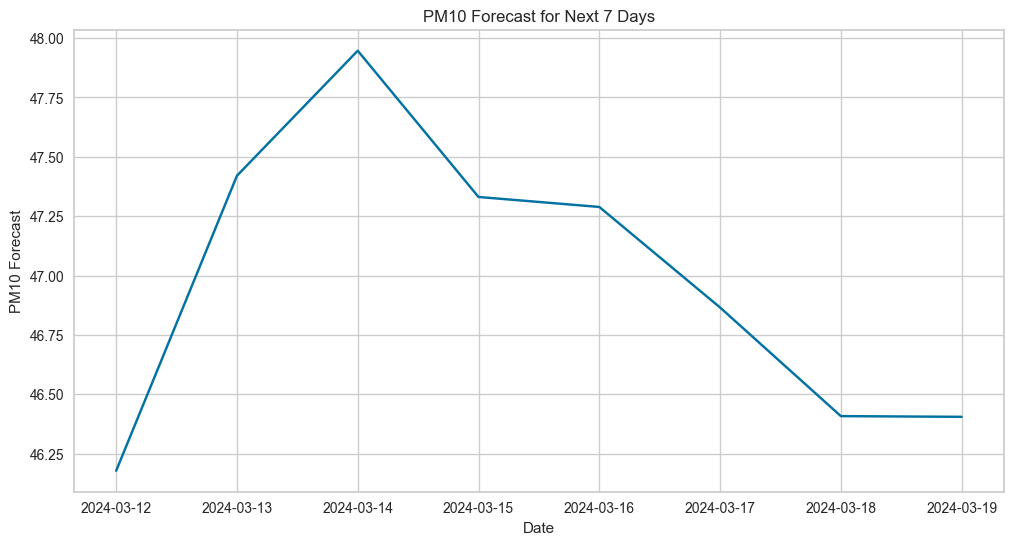

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM10 Forecast')
plt.title('PM10 Forecast for Next 7 Days')
plt.grid(True)
plt.show()

In [11]:
save_model(bagged_model, 'PM10_pipeline')
load_model('PM10_pipeline')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\HP\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['DATETIMEDATA'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['PM25', 'O3', 'CO', 'NO2', 'WS'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model',
                 BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=321),
                                  n_estimators=20, random_state=321))])

In [12]:
mean_value = pd.read_csv('./datafile/mean_value.csv')
PM10_mean = mean_value.drop(columns=['PM25','O3','CO','NO2','SO2','WS','TEMP','RH','WD'])

In [13]:
mpdf = mpdf.rename(columns={"DATETIMEDATA": "Date", "prediction_label": "PM10"})
mpdf['Date'] = mpdf['Date'].dt.date
concat = pd.concat([PM10_mean, mpdf], ignore_index=True)
concat.to_csv('./datafile/PM10_mean_and_week_forecast.csv', index=True)

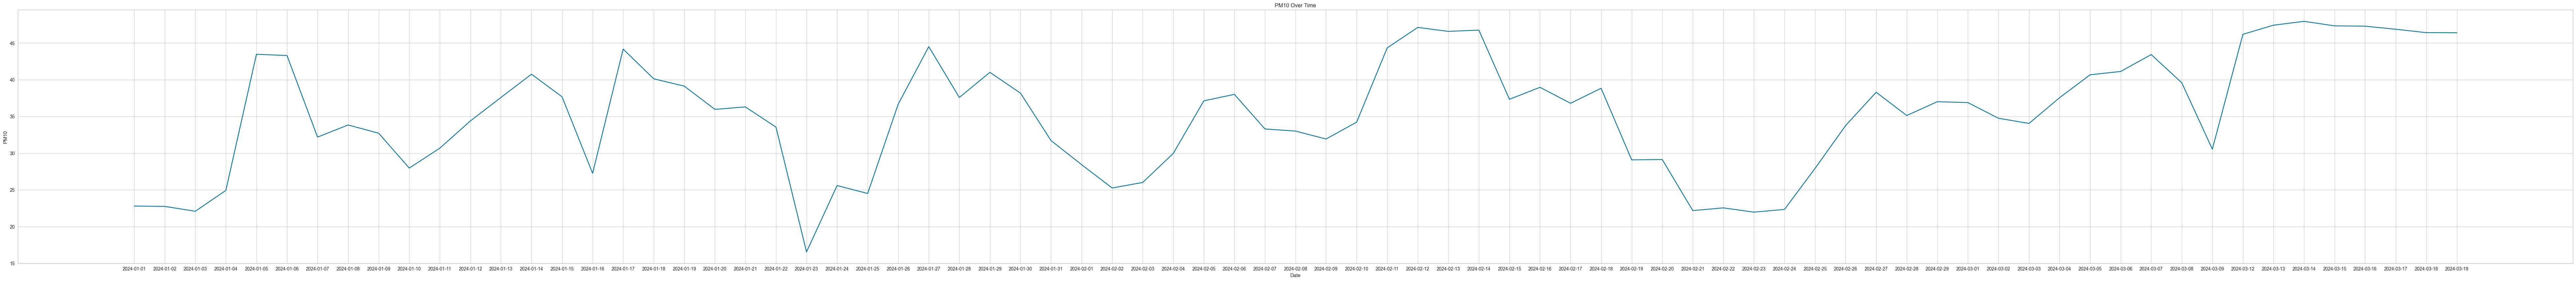

In [14]:
PM10_mean_and_week_forecast = pd.read_csv('./datafile/PM10_mean_and_week_forecast.csv')
dates = PM10_mean_and_week_forecast['Date']
pm10 = PM10_mean_and_week_forecast['PM10']
plt.figure(figsize=(100, 10))
plt.plot(dates, pm10)
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('PM10 Over Time')
plt.grid(True)
plt.show()
plt.show()

In [3]:
import pandas as pd
now = pd.Timestamp.now()
now

Timestamp('2024-03-14 13:13:03.295091')